In [1]:
# source:  https://github.com/activitynet/ActivityNet

In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np
import json

%matplotlib inline

In [17]:
def average_recall_vs_avg_nr_proposals(ground_truth, proposals,
                                       max_avg_nr_proposals=None,
                                       tiou_thresholds=np.linspace(0.5, 0.95, 10)):
    """ Computes the average recall given an average number 
        of proposals per video.
    
    Parameters
    ----------
    ground_truth : df
        Data frame containing the ground truth instances.
        Required fields: ['video-id', 't-start', 't-end']
    proposal : df
        Data frame containing the proposal instances.
        Required fields: ['video-id, 't-start', 't-end', 'score']
    tiou_thresholds : 1darray, optional
        array with tiou thresholds.
        
    Outputs
    -------
    recall : 2darray
        recall[i,j] is recall at ith tiou threshold at the jth average number of average number of proposals per video.
    average_recall : 1darray
        recall averaged over a list of tiou threshold. This is equivalent to recall.mean(axis=0).
    proposals_per_video : 1darray
        average number of proposals per video.
    """

    # Get list of videos.
    video_lst = ground_truth['video-id'].unique()
    
    if not max_avg_nr_proposals:
        max_avg_nr_proposals = float(proposals.shape[0])/video_lst.shape[0]

    ratio = max_avg_nr_proposals*float(video_lst.shape[0])/proposals.shape[0]

    # Adaptation to query faster
    ground_truth_gbvn = ground_truth.groupby('video-id')
    proposals_gbvn = proposals.groupby('video-id')

    # For each video, computes tiou scores among the retrieved proposals.
    score_lst = []
    total_nr_proposals = 0
    for videoid in video_lst:
        # Get ground-truth instances associated to this video.
        ground_truth_videoid = ground_truth_gbvn.get_group(videoid)
        this_video_ground_truth = ground_truth_videoid.loc[:,['t-start', 't-end']].values

        # Get proposals for this video.
        try:
            proposals_videoid = proposals_gbvn.get_group(videoid)
        except:
            n = this_video_ground_truth.shape[0]
            score_lst.append(np.zeros((n, 1)))
            continue

        this_video_proposals = proposals_videoid.loc[:, ['t-start', 't-end']].values

        if this_video_proposals.shape[0] == 0:
            n = this_video_ground_truth.shape[0]
            score_lst.append(np.zeros((n, 1)))
            continue

        # Sort proposals by score.
        sort_idx = proposals_videoid['score'].argsort()[::-1]
        this_video_proposals = this_video_proposals[sort_idx, :]

        if this_video_proposals.ndim != 2:
            this_video_proposals = np.expand_dims(this_video_proposals, axis=0)
        if this_video_ground_truth.ndim != 2:
            this_video_ground_truth = np.expand_dims(this_video_ground_truth, axis=0)

        nr_proposals = np.minimum(int(this_video_proposals.shape[0] * ratio), this_video_proposals.shape[0])
        total_nr_proposals += nr_proposals
        this_video_proposals = this_video_proposals[:nr_proposals, :]

#         print('there')
#         print(this_video_proposals)
#         print(this_video_ground_truth)
        # Compute tiou scores.
        tiou = wrapper_segment_iou(this_video_proposals, this_video_ground_truth)
        score_lst.append(tiou)

    # Given that the length of the videos is really varied, we 
   
    # compute the number of proposals in terms of a ratio of the total 
    # proposals retrieved, i.e. average recall at a percentage of proposals 
    # retrieved per video.

    # Computes average recall.
    pcn_lst = np.arange(1, 101) / 100.0 *(max_avg_nr_proposals*float(video_lst.shape[0])/total_nr_proposals)
    matches = np.empty((video_lst.shape[0], pcn_lst.shape[0]))
    positives = np.empty(video_lst.shape[0])
    recall = np.empty((tiou_thresholds.shape[0], pcn_lst.shape[0]))
    # Iterates over each tiou threshold.
    for ridx, tiou in enumerate(tiou_thresholds):

        # Inspect positives retrieved per video at different 
        # number of proposals (percentage of the total retrieved).
        for i, score in enumerate(score_lst):
            # Total positives per video.
            positives[i] = score.shape[0]
            # Find proposals that satisfies minimum tiou threshold.
            true_positives_tiou = score >= tiou
            # Get number of proposals as a percentage of total retrieved.
            pcn_proposals = np.minimum((score.shape[1] * pcn_lst).astype(np.int), score.shape[1])

            for j, nr_proposals in enumerate(pcn_proposals):
                # Compute the number of matches for each percentage of the proposals
                matches[i, j] = np.count_nonzero((true_positives_tiou[:, :nr_proposals]).sum(axis=1))

        # Computes recall given the set of matches per video.
        recall[ridx, :] = matches.sum(axis=0) / positives.sum()

    # Recall is averaged.
    avg_recall = recall.mean(axis=0)

    # Get the average number of proposals per video.
    proposals_per_video = pcn_lst * (float(total_nr_proposals) / video_lst.shape[0])

    return recall, avg_recall, proposals_per_video


In [18]:
import numpy as np
import json

def interpolated_prec_rec(prec, rec):
    """Interpolated AP - VOCdevkit from VOC 2011.
    """
    mprec = np.hstack([[0], prec, [0]])
    mrec = np.hstack([[0], rec, [1]])
    for i in range(len(mprec) - 1)[::-1]:
        mprec[i] = max(mprec[i], mprec[i + 1])
    idx = np.where(mrec[1::] != mrec[0:-1])[0] + 1
    ap = np.sum((mrec[idx] - mrec[idx - 1]) * mprec[idx])
    return ap


def segment_iou(target_segment, candidate_segments):
    """Compute the temporal intersection over union between a
    target segment and all the test segments.

    Parameters
    ----------
    target_segment : 1d array
        Temporal target segment containing [starting, ending] times.
    candidate_segments : 2d array
        Temporal candidate segments containing N x [starting, ending] times.

    Outputs
    -------
    tiou : 1d array
        Temporal intersection over union score of the N's candidate segments.
    """
    tt1 = np.maximum(target_segment[0], candidate_segments[:, 0])
    tt2 = np.minimum(target_segment[1], candidate_segments[:, 1])
    # Intersection including Non-negative overlap score.
    segments_intersection = (tt2 - tt1).clip(0)
    # Segment union.
    segments_union = (candidate_segments[:, 1] - candidate_segments[:, 0]) \
      + (target_segment[1] - target_segment[0]) - segments_intersection
    # Compute overlap as the ratio of the intersection
    # over union of two segments.
    tIoU = segments_intersection.astype(float) / segments_union
    return tIoU

def wrapper_segment_iou(target_segments, candidate_segments):
    """Compute intersection over union btw segments
    Parameters
    ----------
    target_segments : ndarray
        2-dim array in format [m x 2:=[init, end]]
    candidate_segments : ndarray
        2-dim array in format [n x 2:=[init, end]]
    Outputs
    -------
    tiou : ndarray
        2-dim array [n x m] with IOU ratio.
    Note: It assumes that candidate-segments are more scarce that target-segments
    """
    if candidate_segments.ndim != 2 or target_segments.ndim != 2:
        raise ValueError('Dimension of arguments is incorrect')

    n, m = candidate_segments.shape[0], target_segments.shape[0]
    tiou = np.empty((n, m))
    for i in xrange(m):
        tiou[:, i] = segment_iou(target_segments[i,:], candidate_segments)

    return tiou
                    

## Help functions to evaluate a proposal submission file and plot the metric results

In [19]:
def run_evaluation(ground_truth_filename, proposal_filename, 
                   max_avg_nr_proposals=100, 
                   tiou_thresholds=np.linspace(0.5, 0.95, 10)):

    anet_proposal = ANETproposal(ground_truth_filename, proposal_filename,
                                 tiou_thresholds=tiou_thresholds,
                                 max_avg_nr_proposals=max_avg_nr_proposals)
    anet_proposal.evaluate()
    
    recall = anet_proposal.recall
    average_recall = anet_proposal.avg_recall
    average_nr_proposals = anet_proposal.proposals_per_video
    
    return (average_nr_proposals, average_recall, recall)

def plot_metric(average_nr_proposals, average_recall, recall, tiou_thresholds=np.linspace(0.5, 0.95, 10)):

    fn_size = 14
    plt.figure(num=None, figsize=(6, 5))
    ax = plt.subplot(1,1,1)
    
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    area_under_curve = np.zeros_like(tiou_thresholds)
    for i in range(recall.shape[0]):
        area_under_curve[i] = np.trapz(recall[i], average_nr_proposals)

    for idx, tiou in enumerate(tiou_thresholds[::2]):
        ax.plot(average_nr_proposals, recall[2*idx,:], color=colors[idx+1],
                label="tiou=[" + str(tiou) + "], area=" + str(int(area_under_curve[2*idx]*100)/100.), 
                linewidth=4, linestyle='--', marker=None)

    # Plots Average Recall vs Average number of proposals.
    ax.plot(average_nr_proposals, average_recall, color=colors[0],
            label="tiou = 0.5:0.05:0.95," + " area=" + str(int(np.trapz(average_recall, average_nr_proposals)*100)/100.), 
            linewidth=4, linestyle='-', marker=None)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[-1]] + handles[:-1], [labels[-1]] + labels[:-1], loc='best')
    
    plt.ylabel('Average Recall', fontsize=fn_size)
    plt.xlabel('Average Number of Proposals per Video', fontsize=fn_size)
    plt.grid(b=True, which="both")
    plt.ylim([0, 1.0])
    plt.setp(plt.axes().get_xticklabels(), fontsize=fn_size)
    plt.setp(plt.axes().get_yticklabels(), fontsize=fn_size)

    plt.show()


## Load proposals

In [20]:
%%time


# gt_file = '/usr/local/data01/zahra/datasets/ActivityNet/activity_net.v1-3.min.json'
# scnn_file = '/usr/local/data01/zahra/datasets/ActivityNet/anet_proposals_scnn.json'

gt_file = '/usr/local/data01/zahra/datasets/FACEOFF/tempuckey_ground_truth.json'
scnn_file = '/usr/local/data01/zahra/datasets/FACEOFF/tempuckey_proposals_scnn.json'


with open(gt_file, 'r') as f:
    gt_proposals = json.load(f)
    
with open(scnn_file, 'r') as f:
    scnn_proposals = json.load(f)


CPU times: user 6.23 ms, sys: 797 µs, total: 7.03 ms
Wall time: 5.89 ms


In [21]:
import json
import urllib2

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

class ANETproposal(object):

    def __init__(self, ground_truth_filename=None, proposal_filename=None,
                 tiou_thresholds=np.linspace(0.5, 0.95, 10),
                 max_avg_nr_proposals=None,
                 verbose=False):
        self.tiou_thresholds = tiou_thresholds
        self.max_avg_nr_proposals = max_avg_nr_proposals
        self.verbose = verbose
        self.recall = None
        self.avg_recall = None
        self.proposals_per_video = None
        
        # Import ground truth and proposals.
        self.ground_truth = self._import_ground_truth(ground_truth_filename)
        self.proposal = self._import_proposal(proposal_filename)

        if self.verbose:
            nr_gt = len(self.ground_truth)
            print '\tNumber of ground truth instances: {}'.format(nr_gt)
            nr_pred = len(self.proposal)
            print '\tNumber of proposals: {}'.format(nr_pred)
            print '\tFixed threshold for tiou score: {}'.format(self.tiou_thresholds)

    def _import_ground_truth(self, ground_truth_filename):
        """Reads ground truth file, checks if it is well formatted, and returns
           the ground truth instances and the activity classes.

        Parameters
        ----------
        ground_truth_filename : str
            Full path to the ground truth json file.

        Outputs
        -------
        ground_truth : df
            Data frame containing the ground truth instances.
        activity_index : dict
            Dictionary containing class index.
        """
        with open(ground_truth_filename, 'r') as fobj:
            data = json.load(fobj)

        # Read ground truth data.
        video_lst, t_start_lst, t_end_lst = [], [], []
        for videoid, v in data.items():
            video_lst.append(videoid)

            t_start_lst.append(float(v['segment'][0]))
            t_end_lst.append(float(v['segment'][1]))

        ground_truth = pd.DataFrame({'video-id': video_lst,
                                     't-start': t_start_lst,
                                     't-end': t_end_lst})

        return ground_truth

    def _import_proposal(self, proposal_filename):
        """Reads proposal file, checks if it is well formatted, and returns
           the proposal instances.

        Parameters
        ----------
        proposal_filename : str
            Full path to the proposal json file.

        Outputs
        -------
        proposal : df
            Data frame containing the proposal instances.
        """
        with open(proposal_filename, 'r') as fobj:
            data = json.load(fobj)
        # Read predictions.
        video_lst, t_start_lst, t_end_lst = [], [], []
        score_lst = []
        for videoid, v in data.iteritems():
            for result in v:
                video_lst.append(videoid)
                t_start_lst.append(float(result['segment'][0]))
                t_end_lst.append(float(result['segment'][1]))
                score_lst.append(result['score'])
        proposal = pd.DataFrame({'video-id': video_lst,
                                   't-start': t_start_lst,
                                   't-end': t_end_lst,
                                   'score': score_lst})  

        return proposal

    
    def evaluate(self):
        """Evaluates a proposal file. To measure the performance of a
        method for the proposal task, we computes the area under the 
        average recall vs average number of proposals per video curve.
        """
        recall, avg_recall, proposals_per_video = average_recall_vs_avg_nr_proposals(
                self.ground_truth, self.proposal,
                max_avg_nr_proposals=self.max_avg_nr_proposals,
                tiou_thresholds=self.tiou_thresholds)

        area_under_curve = np.trapz(avg_recall, proposals_per_video)

        if self.verbose:
            print '[RESULTS] Performance on ActivityNet proposal task.'
            print '\tArea Under the AR vs AN curve: {}%'.format(100.*float(area_under_curve)/proposals_per_video[-1])

        self.recall = recall
        self.avg_recall = avg_recall
        self.proposals_per_video = proposals_per_video


## Uniform Proposals

In [26]:
# compare the ground truth with uniform randome porposals


## Evaluate scnn proposals and plot the metric results

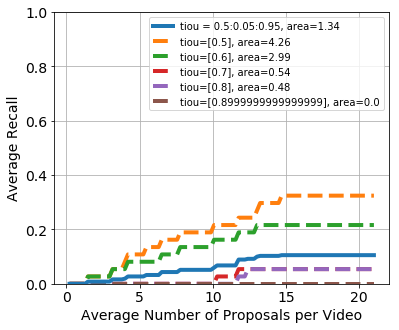

CPU times: user 350 ms, sys: 144 ms, total: 493 ms
Wall time: 295 ms


In [25]:
%%time

scnn_average_nr_proposals, scnn_average_recall, scnn_recall = run_evaluation(
    gt_file,
    scnn_file,
    max_avg_nr_proposals=21,
    tiou_thresholds=np.linspace(0.5, 0.95, 10))

plot_metric(scnn_average_nr_proposals, scnn_average_recall, scnn_recall)
